# 08 Cell type deconvolution

- Åsa Björklund
- Paulo Czarnewski

- Spatial Omics Data Analysis 2022

Deconvolution is a method to estimate the abundance (or proportion) of different celltypes in a bulkRNAseq dataset using a single cell reference. As the Visium data can be seen as a small bulk, we can both use methods for traditional bulkRNAseq as well as methods especially developed for Visium data. Some methods for deconvolution are DWLS, cell2location, Tangram, Stereoscope, RCTD, SCDC and many more.

Here, we will use deconvolution with Stereoscope implemented in the SCVI-tools package. To read more about Stereoscope please check out this github page (https://github.com/almaan/stereoscope)

In [4]:
import scvi

Global seed set to 0
/Users/Czarnewski/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [6]:
# from scvi.data import register_tensor_from_anndata
from scvi.external import RNAStereoscope, SpatialStereoscope

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import scanorama
import os

## Subsetting the single cell dataset

In order to reduce computational time and equalise the amount of cell in each of the cluster (to avoid biasing the downstream analysis). To this end, we will randomely select `N` cells from each cluster. 

We can first load both out single cell and Spatial Trancriptomics dataset (Visium) that we analysed in the previous steps.

In [99]:
%%bash
tree ../results/

../results/
├── in_situ_sequencing
├── regev_lab_cell_cycle_genes.txt
├── single_cell
│   ├── scRNAseq.h5ad
│   ├── single_cell_qc.h5ad
│   ├── single_cell_qc_int_dr.h5ad
│   └── single_cell_qc_int_dr_cl.h5ad
├── spatial_transcriptomics
│   ├── spatial_transcriptomics_qc_int_dr_cl.h5ad
│   ├── stereoscope_model
│   │   └── model.pt
│   └── visium.h5ad
└── supplementary_files
    └── regev_lab_cell_cycle_genes.txt

5 directories, 9 files


In [129]:
sc_adata = sc.read_h5ad('../results/single_cell/single_cell_qc_int_dr_cl.h5ad')
sc_adata

visium_adata = sc.read_h5ad('../results/spatial_transcriptomics/spatial_transcriptomics_qc_int_dr_cl.h5ad')
visium_adata.obs_names_make_unique()

/Users/Czarnewski/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


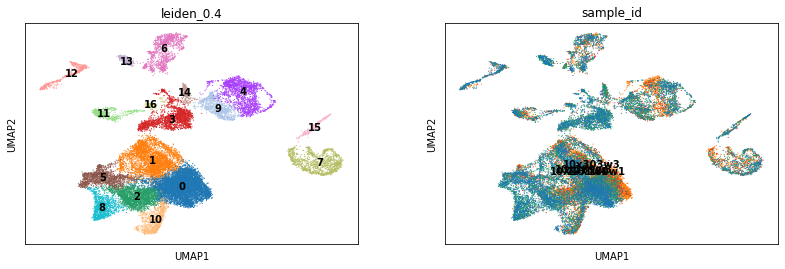

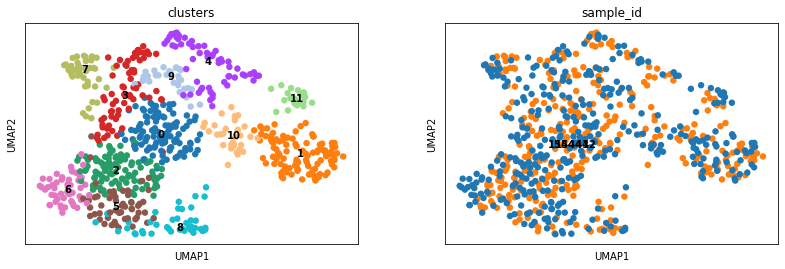

In [103]:
sc.pl.umap(
    adata = sc_adata, 
    color = ["leiden_0.4","sample_id"], 
    legend_loc = 'on data')

sc.pl.umap(
    adata = visium_adata,
    color = ["clusters", "sample_id"],
    legend_loc = 'on data')

With datasets loaded we can now subtet the `single cell` dataset. We have chosen 20 here for the purpose of this tutorial, but anywhere around 50 cells should be enough to represent even the finest cell states.

In [104]:
subset_SC_adata = {}
for batch in sc_adata.obs['leiden_0.4'].unique():
    subset_SC_adata[batch] = sc_adata[sc_adata.obs['leiden_0.4'].isin([batch])]
    sc.pp.subsample( subset_SC_adata[batch], n_obs=20 )

And then we can merge the objects into a single subseted version of it

In [105]:
# Merge all samples into a single AnnData Object 
subset_SC_adata = an.concat( subset_SC_adata , merge='same' )
subset_SC_adata

AnnData object with n_obs × n_vars = 340 × 2000
    obs: 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'louvain_0.4', 'leiden_0.4', 'louvain_0.6', 'leiden_0.6', 'louvain_0.8', 'leiden_0.8', 'louvain_0.9', 'leiden_0.9', 'louvain_1.0', 'leiden_1.0', 'louvain_1.1', 'leiden_1.1', 'louvain_1.2', 'leiden_1.2', 'louvain_1.4', 'leiden_1.4', 'louvain_1.6', 'leiden_1.6'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    obsm: 'X_pca', 'X_umap', 'scanorama'
    varm: 'PCs'

## Selecting genes for deconvolution

Most deconvolution methods does a prior gene selection and there are different options that are used:
- Use variable genes in the SC data.
- Use variable genes in both SC and ST data
- DE genes between clusters in the SC data.

Here, we will re-compute the highly variable genes on the single cell dataset and filter out genes that can't be found in the Visium dataset.

In [106]:
sc.pp.highly_variable_genes(
    adata = subset_SC_adata, 
    n_top_genes = 1000,
    inplace = True, 
    batch_key = "sample_id")

/Users/Czarnewski/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/Users/Czarnewski/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/Czarnewski/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/Users/Czarnewski/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

In [108]:
deg = subset_SC_adata.var.index[ subset_SC_adata.var['highly_variable'] ]
deg = deg.unique().tolist()
print(len(deg))

1000


And now we have to check that the genes are also present in the ST data.

In [136]:
deg = np.intersect1d( deg , visium_adata.var.index ).tolist()
print(len(deg))
deg

1000


['ABCA4',
 'ABCA6',
 'ABCA7',
 'ABCA9-AS1',
 'ABCB1',
 'ABCC9',
 'ABCG2',
 'ABI3BP',
 'AC004233.2',
 'AC004264.1',
 'AC005261.2',
 'AC006058.1',
 'AC006369.1',
 'AC007319.1',
 'AC008415.1',
 'AC008467.1',
 'AC008764.1',
 'AC009060.1',
 'AC010531.6',
 'AC011498.6',
 'AC012447.1',
 'AC012574.1',
 'AC015914.1',
 'AC016831.7',
 'AC018647.1',
 'AC019197.1',
 'AC020656.1',
 'AC024267.1',
 'AC026471.3',
 'AC046168.2',
 'AC069234.1',
 'AC069277.1',
 'AC073610.2',
 'AC074327.1',
 'AC087276.2',
 'AC092691.1',
 'AC092957.1',
 'AC103702.2',
 'AC104389.4',
 'AC105383.1',
 'AC109466.1',
 'AC110799.1',
 'AC112206.2',
 'AC116407.1',
 'AC130456.3',
 'AC133550.1',
 'AC142391.1',
 'AC147651.4',
 'AC245014.3',
 'ACP5',
 'ACSL1',
 'ACTA2',
 'ACTC1',
 'ACTG2',
 'ACTL6B',
 'ACVRL1',
 'ADAM15',
 'ADARB2',
 'ADCY8',
 'ADD2',
 'ADGRF3',
 'ADGRF5',
 'ADGRG1',
 'ADGRL4',
 'ADGRV1',
 'AEN',
 'AFAP1L1',
 'AGBL4',
 'AGER',
 'AGR2',
 'AGRN',
 'AGT',
 'AHNAK2',
 'AHSP',
 'AIF1',
 'AJAP1',
 'AKAP6',
 'AL022328.4',
 'AL

## Train Stereoscope model on the Single Cell dataset

In [112]:
# add counts layer
subset_SC_adata = subset_SC_adata.raw.to_adata()
subset_SC_adata.layers["counts"] = subset_SC_adata.X.copy()

In [113]:
# subset for the selected genes
subset_SC_adata = subset_SC_adata[:, deg].copy()

In [115]:
# create stereoscope object
RNAStereoscope.setup_anndata(
    adata = subset_SC_adata, 
    layer = "counts", 
    labels_key = "leiden_0.4")

The model is saved to a file, so if is slow to run, you can simply reload it from disk by setting `train = False`.

/Users/Czarnewski/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=300 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Czarnewski/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 300/300: 100%|████████| 300/300 [00:20<00:00, 14.96it/s, loss=3.67e+05, v_num=1]


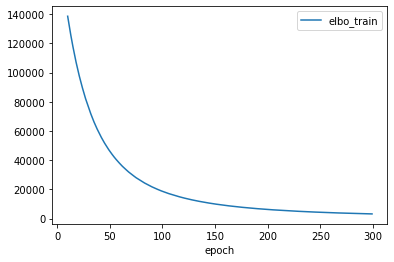

In [116]:
train = True

if train:
    sc_model = RNAStereoscope(subset_SC_adata)
    sc_model.train(max_epochs = 300)
    sc_model.history["elbo_train"][10:].plot()
    sc_model.save("../results/spatial_transcriptomics/SC_model", overwrite=True)
else:
    sc_model = RNAStereoscope.load(
        dir_path = "../results/spatial_transcriptomics/SC_model", 
        adata = subset_SC_adata)
    print("Loaded RNA model from file!")

## Predict propritions on the spatial data

First create a new st object with the correct genes and counts as a layer. We will subset the the genes in the Visium dataset to match the number of genes used to train the Stereoscope model (1000 in this case).

In [142]:
subset_visium_adata = visium_adata.raw.to_adata().copy()
subset_visium_adata = subset_visium_adata[:, deg].copy()
subset_visium_adata.layers["counts"] = subset_visium_adata.X.copy()
subset_visium_adata

AnnData object with n_obs × n_vars = 716 × 1000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'S_score', 'G2M_score', 'phase', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'clusters_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'sample_id_colors', 'spatial', 'umap'
    obsm: 'Scanorama', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [143]:
SpatialStereoscope.setup_anndata(subset_visium_adata, layer="counts")

/Users/Czarnewski/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=300 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/Czarnewski/opt/miniconda3/envs/spatial2022/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 300/300: 100%|████████| 300/300 [00:34<00:00,  8.69it/s, loss=3.56e+05, v_num=1]


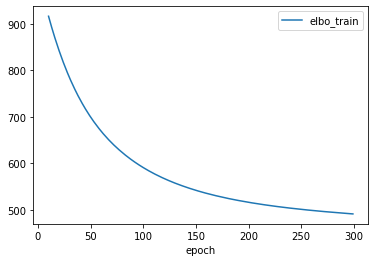

In [144]:
train=True
if train:
    spatial_model = SpatialStereoscope.from_rna_model(
        st_adata = subset_visium_adata, sc_model = sc_model)
    spatial_model.train(max_epochs = 300)
    spatial_model.history["elbo_train"][10:].plot()
    spatial_model.save("../results/spatial_transcriptomics/ST_model", overwrite = True)
else:
    spatial_model = SpatialStereoscope.load("../results/spatial_transcriptomics/ST_model", subset_visium_adata)
    print("Loaded Spatial model from file!")

Get the results from the model, also put them in the `.obs` slot of the UNFILTERED original Visium object with all cell, so we can visualize both the deconvolution of cell types and the gene expression.

In [145]:
visium_adata.obsm["stereoscope"] = spatial_model.get_proportions()

# also copy to the obsm data frame
for ct in visium_adata.obsm["stereoscope"].columns:
    visium_adata.obs[ct] = visium_adata.obsm["stereoscope"][ct]

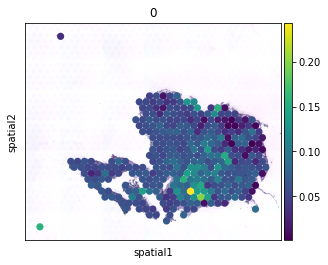

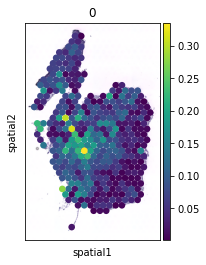

In [152]:
for library in visium_adata.obs.sample_id.unique():
    sc.pl.spatial(
      visium_adata[visium_adata.obs.sample_id == library,:],
      color      = ["0"],
      library_id = library,
      size       = 1.5,
      ncols      = 2)

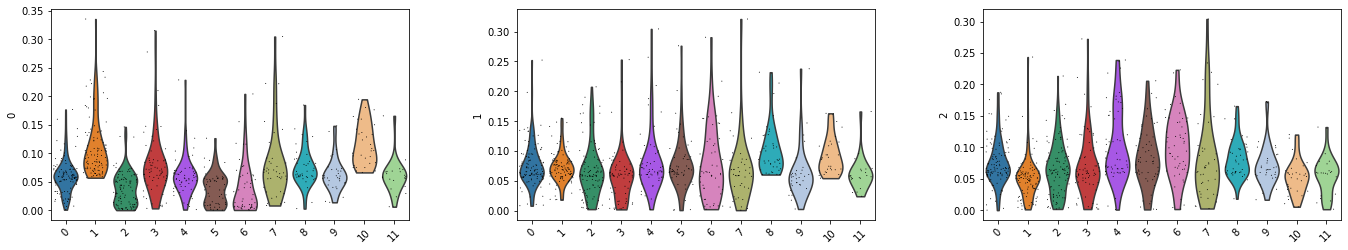

In [162]:
sc.pl.violin(
    visium_adata,
    groupby = 'clusters',
    keys = ["0","1","2"],
    jitter=0.4,
    rotation= 45)

In [ ]:
visium_adata.obs.sample_id.unique()

Lets save the integrated data for further analysis.

In [164]:
os.makedirs('../results/spatial_transcriptomics', exist_ok=True)
adata.write_h5ad('../results/spatial_transcriptomics/spatial_transcriptomics_qc_int_dr_cl_deconv.h5ad')